In [42]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import glob
import os
import random
import pandas as pd
import numpy as np
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

#importing various metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

# importing model relevant dependencies
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras import optimizers, regularizers
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras import backend as K
K.clear_session()

In [43]:
# EDA with images in the directory
train_dir = 'dogs-vs-cats/train'
test_dir = 'dogs-vs-cats/test1'

In [44]:
# let's explore a sample file and how to extract label and file name from it.

for _ in range(5):
    print(random.choice(os.listdir(train_dir)))

dog.7379.jpg
cat.6250.jpg
dog.11570.jpg
cat.1396.jpg
dog.7863.jpg


In [45]:
for _ in range(5):
    print(random.choice(os.listdir(test_dir)))

8889.jpg
2979.jpg
8590.jpg
5187.jpg
3780.jpg


In [46]:
# saving extracted data into dataframe for further processing
def label(path):
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

x_train_images_name = filename(train_dir)
x_test_images_name = filename(test_dir)
y_train_label_name = label(train_dir)

#creating df with name and label

df_train_image = pd.DataFrame({'filename':x_train_images_name, 'label':y_train_label_name})
df_submission = pd.DataFrame({'filename':x_test_images_name})

In [47]:
df_train_image.head()

,filename,label
0,cat.4422.jpg,cat
1,dog.7017.jpg,dog
2,dog.9722.jpg,dog
3,cat.5652.jpg,cat
4,dog.3921.jpg,dog


In [48]:
df_submission.head()

,filename
0,5101.jpg
1,9391.jpg
2,6135.jpg
3,11140.jpg
4,10797.jpg


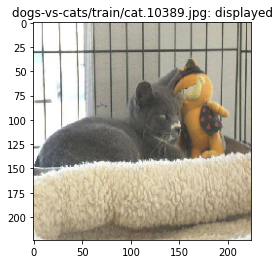

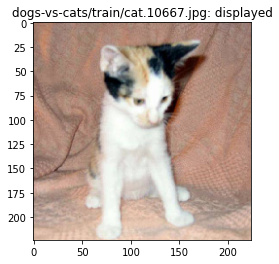

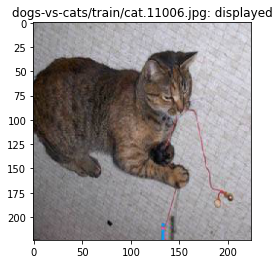

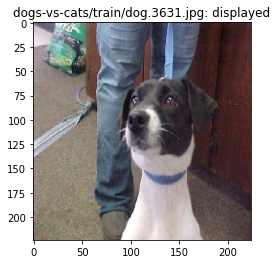

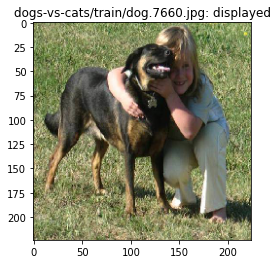

In [49]:
# training directory
for _ in range(5):
    file_name = train_dir + "/"+ random.choice(os.listdir(train_dir))
    #read image
    image = load_img(file_name, target_size=(224,224))
    plt.imshow(image)
    plt.title("{}: displayed".format(file_name))
    plt.show()

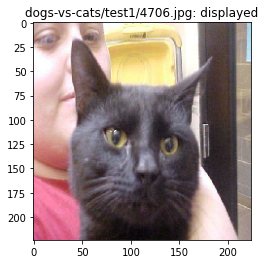

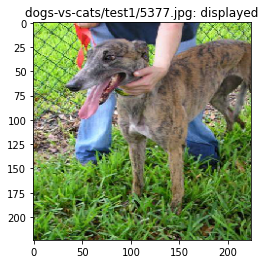

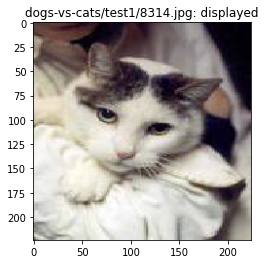

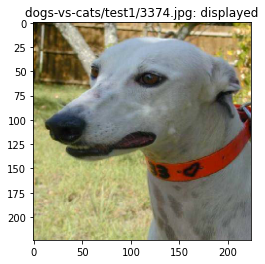

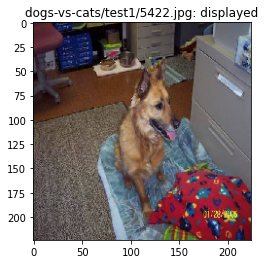

In [50]:
# test directory
for _ in range(5):
    file_name = test_dir + "/"+ random.choice(os.listdir(test_dir))
    #read image
    image = load_img(file_name, target_size=(224,224))
    plt.imshow(image)
    plt.title("{}: displayed".format(file_name))
    plt.show()

In [51]:
# splitting the data into train test
train_val_df, test_df = train_test_split(df_train_image, test_size=0.02)
# splitting the train val further into train, val
train_df, val_df = train_test_split(train_val_df, test_size=0.2)

print("Total number of images in the train is {}".format(train_df.shape[0]))
print("Total number of images in the internal test is {}".format(test_df.shape[0]))
print("Total number of images in the val is {}".format(val_df.shape[0]))
print("Total number of images in the submission is {}".format(df_submission.shape[0]))

Total number of images in the train is 19600
Total number of images in the internal test is 500
Total number of images in the val is 4900
Total number of images in the submission is 12500


In [71]:
# Image augmentation data preparation with Image Data Generator
img_size = 224
batch_size = 1024
train_aug_map = ImageDataGenerator(
                rotation_range=10,
                horizontal_flip = True,
                fill_mode = 'nearest',
                preprocessing_function = preprocess_input)

train_data = train_aug_map.flow_from_dataframe(
                            train_df, train_dir,
                            x_col='filename',
                            y_col = 'label',
                            target_size = (img_size, img_size),
                            batch_size= batch_size,
                            class_mode='categorical')


val_aug_mag = ImageDataGenerator(
                preprocessing_function = preprocess_input)

val_data = val_aug_mag.flow_from_dataframe(
                            val_df, train_dir,
                            x_col='filename',
                            y_col = 'label',
                            target_size = (img_size, img_size),
                            batch_size= batch_size,
                            class_mode='categorical')

test_aug_map = ImageDataGenerator(
                preprocessing_function = preprocess_input)

test_data = val_aug_mag.flow_from_dataframe(
                            test_df, train_dir,
                            x_col='filename',
                            y_col = 'label',
                            class_mode = 'categorical',
                            target_size = (img_size, img_size),
                            shuffle = False)

Found 19600 validated image filenames belonging to 2 classes.
Found 4900 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [53]:
# building mobile net model
mobilenet = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224,224,3))
mobilenet.trainable = False
mobilenet_model = Sequential([mobilenet,Flatten(),Dense(1024, activation='relu'),
                             Dropout(0.4), Dense(2,activation='softmax')])

optimizer = tf.keras.optimizers.Adam(1e-6)

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 1, 1, 1280)        4226432   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 5,540,226
Trainable params: 1,313,794
Non-trainable params: 4,226,432
_________________________________________________________________


In [54]:
# early stopping criterion

epoch = 50
learning_rate = 3e-5
lr_start = 0.00000001
lr_min = 0.000001
lr_max = 3e-5
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8

def adjustable_lr(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr


early_stop = EarlyStopping(patience=5)
lr_callback = LearningRateScheduler(adjustable_lr, verbose=True)
callbacks = [early_stop, lr_callback]

In [55]:
mobilenet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
train_images = train_df.shape[0]
val_images = val_df.shape[0]
history = mobilenet_model.fit_generator(
    train_data, epochs=5,
    validation_data=val_data, validation_steps=val_images//batch_size, steps_per_epoch=train_images//batch_size, callbacks=callbacks)

Epoch 1/5

Epoch 00001: LearningRateScheduler setting learning rate to 1e-08.
19/19 [==============================] - 252s 13s/step - loss: 0.8155 - accuracy: 0.4820 - val_loss: 0.7667 - val_accuracy: 0.4561
Epoch 2/5

Epoch 00002: LearningRateScheduler setting learning rate to 3e-05.
19/19 [==============================] - 243s 13s/step - loss: 0.4751 - accuracy: 0.7722 - val_loss: 0.2316 - val_accuracy: 0.9548
Epoch 3/5

Epoch 00003: LearningRateScheduler setting learning rate to 3e-05.
19/19 [==============================] - 242s 13s/step - loss: 0.2026 - accuracy: 0.9428 - val_loss: 0.1259 - val_accuracy: 0.9783
Epoch 4/5

Epoch 00004: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
19/19 [==============================] - 240s 13s/step - loss: 0.1347 - accuracy: 0.9653 - val_loss: 0.1019 - val_accuracy: 0.9790
Epoch 5/5

Epoch 00005: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
19/19 [==============================] - 243s 13s/st

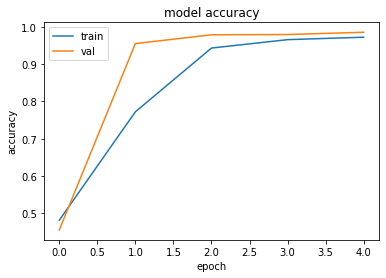

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

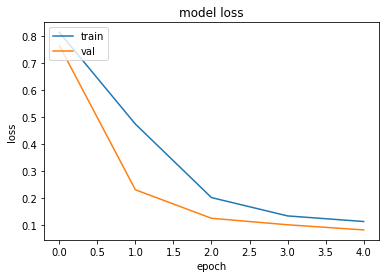

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
mobilenet_model.evaluate(test_data)

16/16 [==============================] - 2s 95ms/step - loss: 0.0826 - accuracy: 0.9880


[0.08262686431407928, 0.9879999756813049]

In [104]:
test_aug_map = ImageDataGenerator(
                preprocessing_function = preprocess_input)

mission_data = test_aug_map.flow_from_dataframe(
                            df_submission, test_dir,
                            x_col='filename',
                            y_col = None,
                            class_mode = None,
                            target_size = (img_size, img_size),
                            shuffle = False)

# mission_data = val_aug_mag.flow_from_dataframe(
#                             df_submission, test_dir,
#                             x_col='filename',
#                             y_col = None,
#                             class_mode = None,
#                             target_size = (img_size, img_size),
#                             shuffle = False)

Found 12500 validated image filenames.


In [110]:
sub_pred = mobilenet_model.predict(mission_data)

(12500, 2)

In [118]:
sub_pred[:, 1]

array([0.98849213, 0.00534693, 0.03391513, ..., 0.00488794, 0.03995133,
       0.0043021 ], dtype=float32)

In [120]:
submission_df = pd.read_csv("dogs-vs-cats/sampleSubmission.csv")
submission_df['pred'] = sub_pred[:, 1]
submission_df.head(10)

,id,label,pred
0,1,0,0.988492
1,2,0,0.005347
2,3,0,0.033915
3,4,0,0.988531
4,5,0,0.020471
5,6,0,0.945272
6,7,0,0.025746
7,8,0,0.004972
8,9,0,0.921826
9,10,0,0.056703


In [121]:
submission_df['label'] = submission_df['pred'].apply(lambda x: 1 if x > 0.5 else 0)

submission_df.head(10)

,id,label,pred
0,1,1,0.988492
1,2,0,0.005347
2,3,0,0.033915
3,4,1,0.988531
4,5,0,0.020471
5,6,1,0.945272
6,7,0,0.025746
7,8,0,0.004972
8,9,1,0.921826
9,10,0,0.056703


In [126]:
submission_df.to_csv('submission.csv', index=False)